In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
43,831 cases (7 day average) as of Mon 19 Jul, +406.0 since Sun 18 Jul
702 hospitalised (7 day average) as of Wed 21 Jul, +0.0 since Wed 21 Jul
42 died (7 day average) as of Mon 19 Jul, +5.6 since Sun 18 Jul


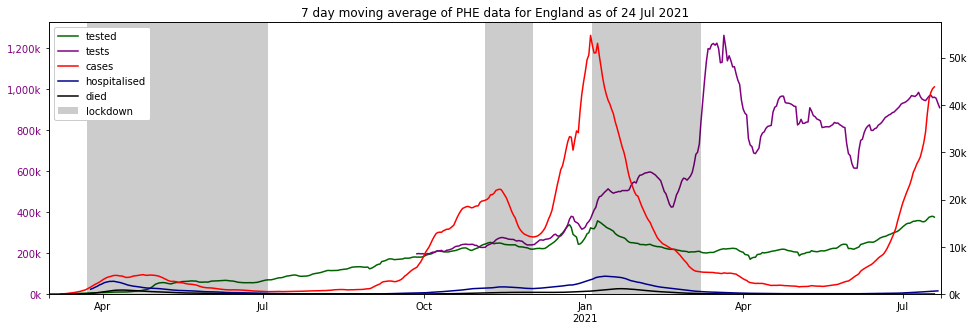

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

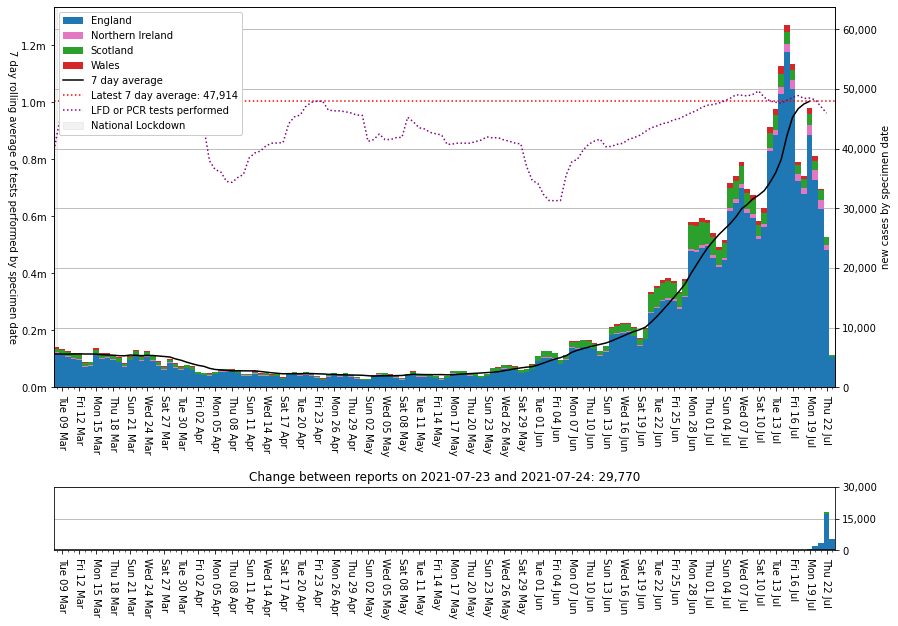

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

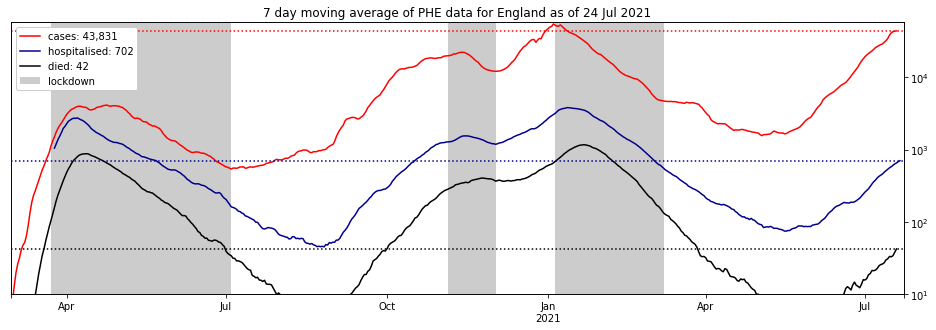

In [5]:
plot_summary(earliest_date='2020-02-29', show_latest='lines', log=True,
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

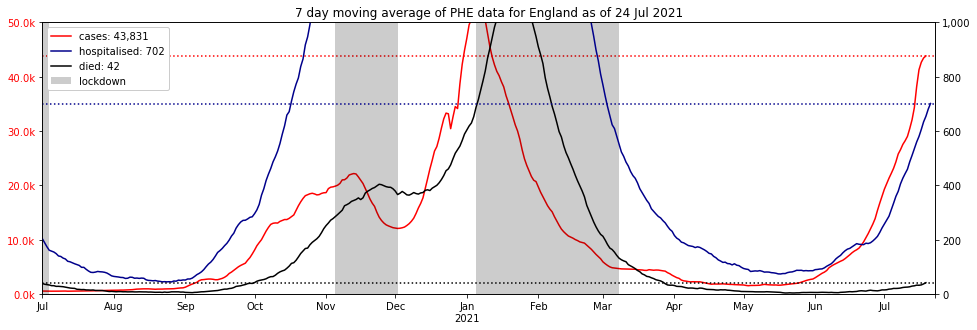

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=50_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=1000)

In [7]:
vaccination_changes()

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,30909329.0,39045107.0,8135778.0,56286961,54.913835,14.454108,30.632057
1,Northern Ireland,N92000002,1006725.0,1193854.0,187129.0,1893667,53.162726,9.881832,36.955441
2,Scotland,S92000003,3064441.0,3994883.0,930442.0,5463300,56.091392,17.030769,26.877839
3,Wales,W92000004,1973196.0,2286154.0,312958.0,3152879,62.583943,9.926102,27.489954


'partial: 46,519,998 (69.6%), full: 36,953,691'

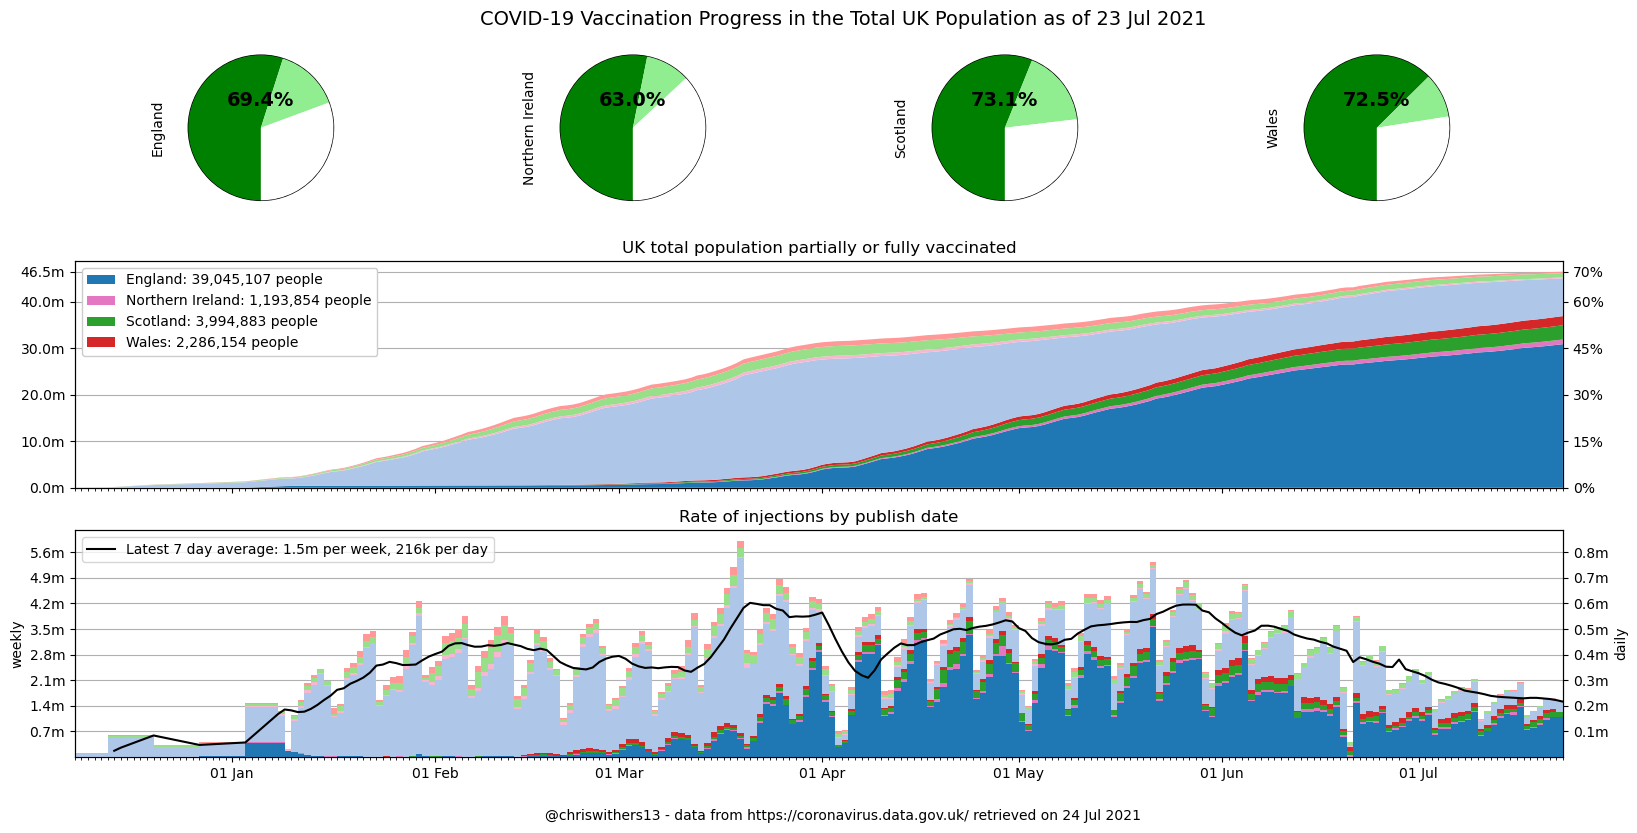

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

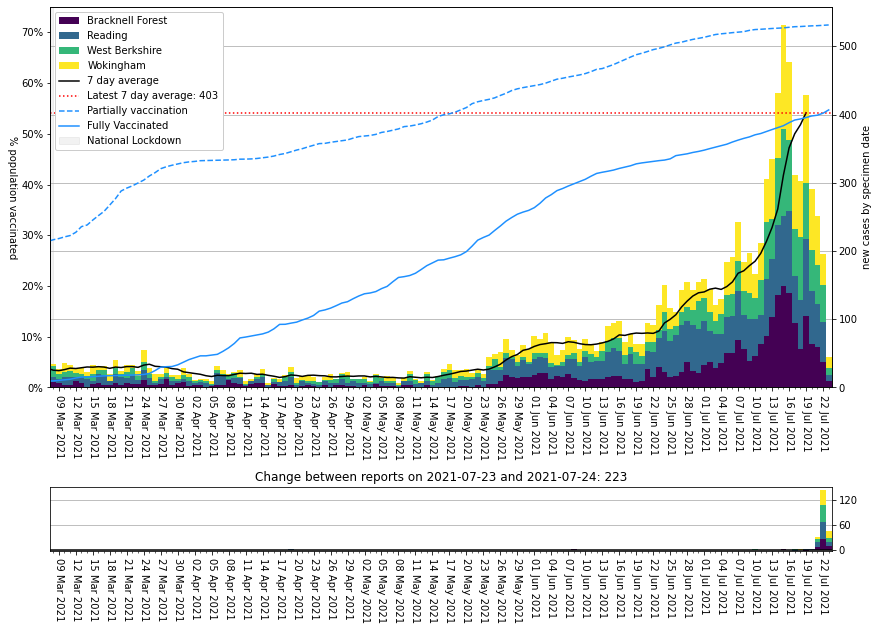

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], lines=population_vaccinated)

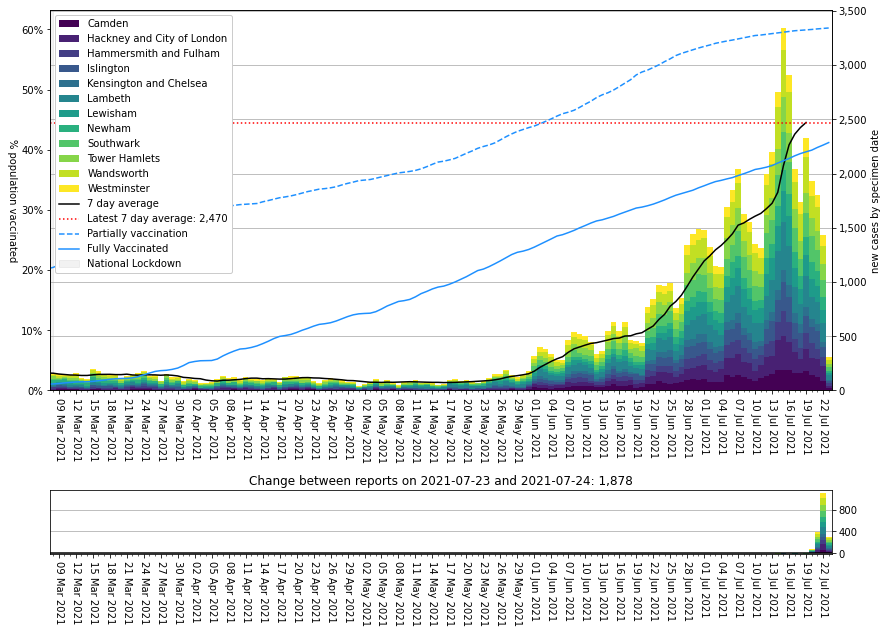

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000003,Redcar and Cleveland,888.078746,1218.0,2021-07-23
E06000002,Middlesbrough,863.243013,1217.0,2021-07-23
E06000004,Stockton-on-Tees,761.092081,1502.0,2021-07-23
N09000003,Belfast,684.341361,2351.0,2021-07-23
E06000001,Hartlepool,656.609333,615.0,2021-07-23
E06000012,North East Lincolnshire,648.019904,1034.0,2021-07-23
E08000023,South Tyneside,644.473294,973.0,2021-07-23
E07000029,Copeland,633.589018,432.0,2021-07-23
E08000024,Sunderland,599.557084,1665.0,2021-07-23


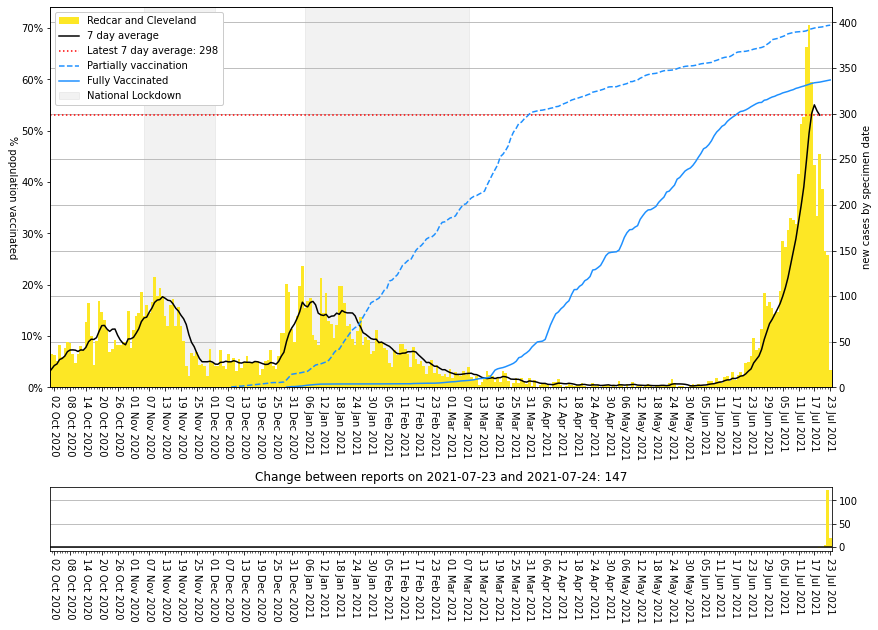

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,364.944965,4167.0,2021-07-23
E08000035,Leeds,429.306843,3405.0,2021-07-23
E06000047,County Durham,485.574257,2574.0,2021-07-23
E06000023,"Bristol, City of",522.684553,2422.0,2021-07-23
E08000032,Bradford,442.776263,2390.0,2021-07-23
N09000003,Belfast,684.341361,2351.0,2021-07-23
E08000019,Sheffield,401.468403,2348.0,2021-07-23
E08000003,Manchester,379.482616,2098.0,2021-07-23
E08000017,Doncaster,597.005354,1862.0,2021-07-23


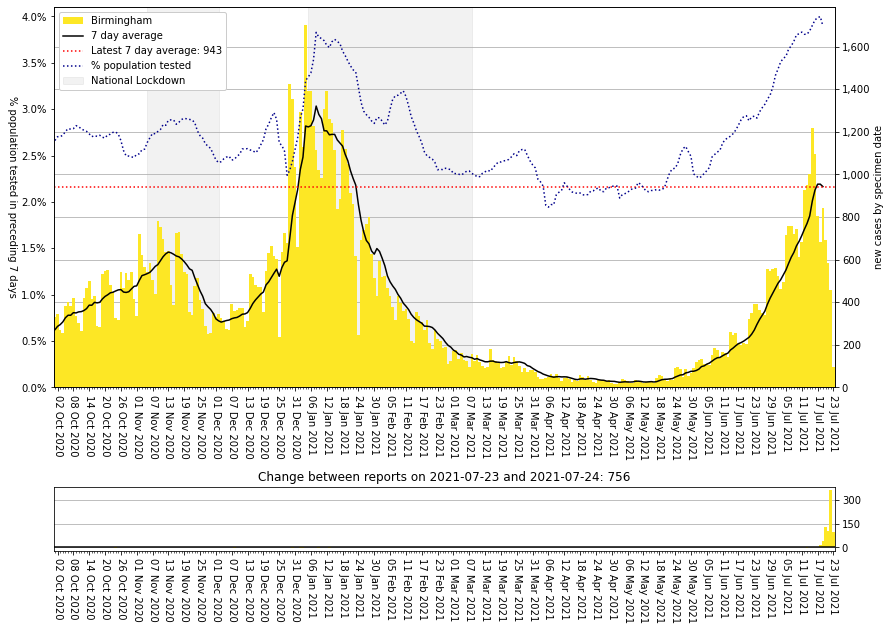

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 3.0
phe_max = 1.3

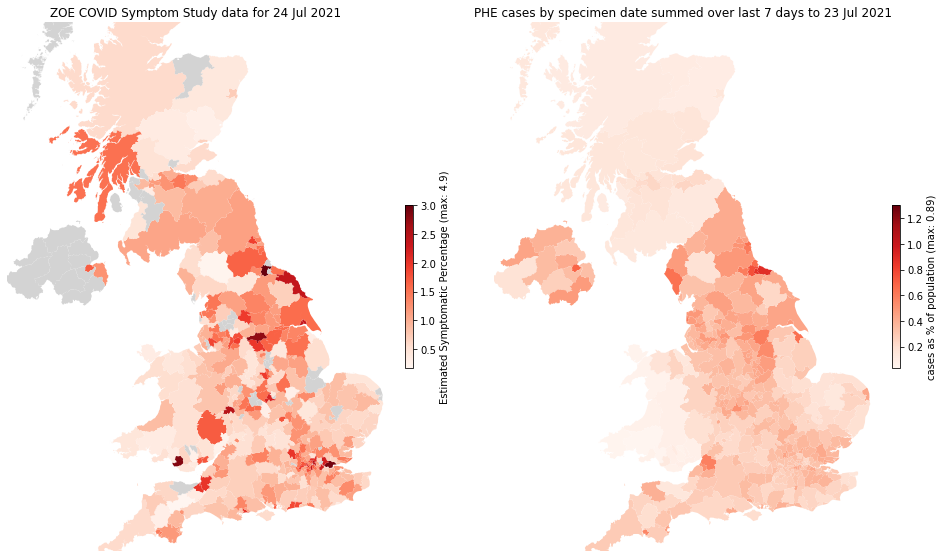

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...